## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import KFold
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import *
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
105503,00028357_029.png,No Finding,29,28357,52,M,AP,2544,3056,0.139,0.139,NaN,/data/images_012/images/00028357_029.png
24546,00006451_006.png,Infiltration,6,6451,55,F,PA,2992,2991,0.143,0.143,NaN,/data/images_003/images/00006451_006.png
57043,00014173_003.png,No Finding,3,14173,63,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014173_003.png


In [4]:
all_xray_df['View Position'].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

In [18]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_xray_df['pneumonia_class']=np.where(all_xray_df['Finding Labels'].str.contains('Pneumonia'),"yes","no")


## Create your training and testing data:

In [20]:
from sklearn.model_selection import train_test_split
def create_splits(df,test_split,target_col):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data=train_test_split( df, test_size=test_split,stratify=df[target_col], random_state=42)
    return train_data, val_data
train_df, val_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')


In [27]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,is_pneumonia,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0,no
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0,no
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0,no
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0,no
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030801_001.png,1,yes
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030802_000.png,0,no
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030803_000.png,0,no
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030804_000.png,0,no


#### Above Train test split resulted in a degraded model , since the split is highly Imbalances , Hence modified below

In [31]:
def create_splits(df):
    
    train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['pneumonia_class'])
    
    p_idx = train_df[train_df.pneumonia_class=="yes"].index.tolist()
    nop_idx = train_df[train_df.pneumonia_class=="no"].index.tolist()
    ns = sample(nop_idx, len(p_idx))
    train_df = train_df.loc[p_idx + ns]
    train_df_ratio = len(train_df[train_df.pneumonia_class=="yes"])/len(train_df)
    print(f'Percentage of Pneumonia samples in training set: {100.0*train_df_ratio :.2f}%')
    
    p_idx = valid_df[valid_df.pneumonia_class=="yes"].index.tolist()
    nop_idx = valid_df[valid_df.pneumonia_class=="no"].index.tolist()
    ns = sample(nop_idx, 4*len(p_idx))
    valid_df = valid_df.loc[p_idx + ns]
    valid_df_ratio = len(valid_df[valid_df.pneumonia_class=="yes"])/len(valid_df)
    print(f'Percentage of Pneumonia samples in validation set: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df

In [32]:
train_df, valid_df = create_splits(all_xray_df)

Percentage of Pneumonia samples in training set: 50.00%
Percentage of Pneumonia samples in validation set: 20.00%


In [33]:
print(len(train_df),      "\n",train_df['is_pneumonia'].value_counts())
print(len(val_df),      "\n",val_df['is_pneumonia'].value_counts())

2290 
 1    1145
0    1145
Name: is_pneumonia, dtype: int64
22424 
 0    22138
1      286
Name: is_pneumonia, dtype: int64


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [34]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # horizontal_flip and vertical_flip will be set to True/False
    # height_shift_range and width_shift_range can be between 0 and 1
    # rotation_range can be between 0 and 180
    # shear_range can be between 0 and 1
    # zoom_range can be between 0 and 1
    my_idg = ImageDataGenerator(rescale = 1 / 255.0,
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.1, 
                             width_shift_range = 0.1, 
                             rotation_range = 25, 
                             shear_range = 0.1,
                             zoom_range = 0.2)
    
    return my_idg


def make_train_gen(my_train_idg,train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col ='path' ,
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 64
                                         )
     # Todo

    return train_gen


def make_val_gen(val_data):
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col ='path' ,
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 64 ) 
    
    # Todo
    return val_gen

In [35]:
imageDataGenerator = my_image_augmentation()
train_gen = make_train_gen(imageDataGenerator, train_df)

Found 2290 validated image filenames belonging to 2 classes.


In [36]:
## May want to pull a single large batch of random validation data for testing after each epoch:

val_gen = make_val_gen(val_df)
valX, valY = val_gen.next()

Found 22424 validated image filenames belonging to 2 classes.


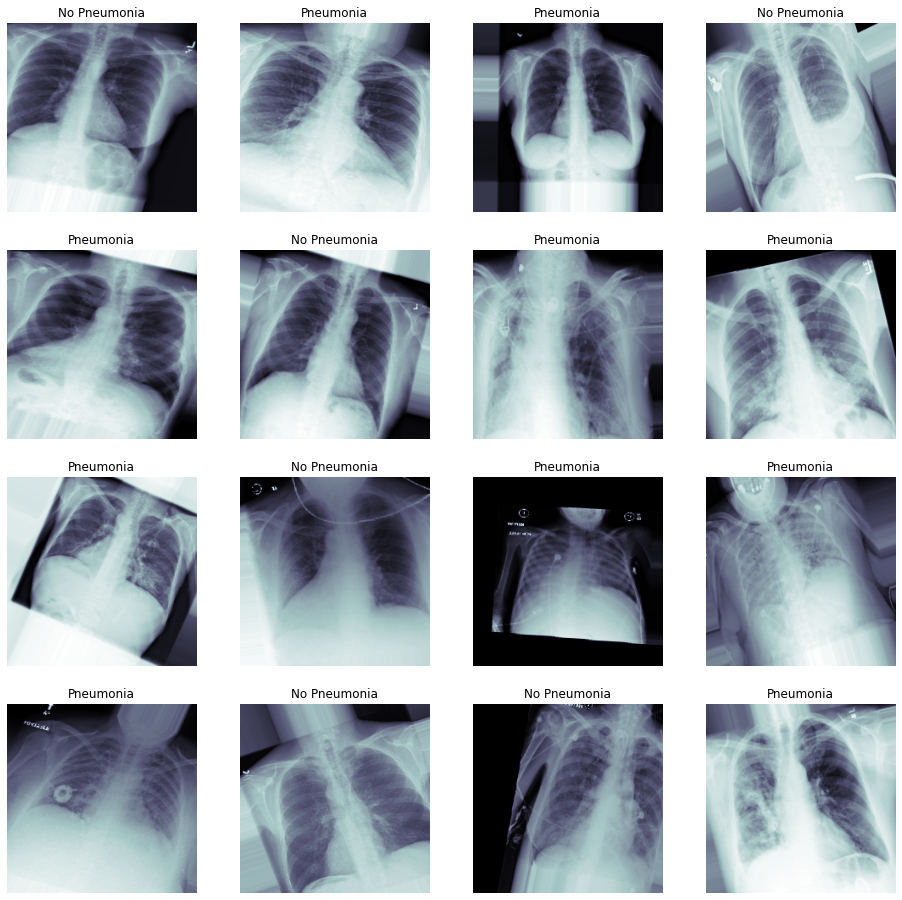

In [37]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [38]:
def load_pretrained_model(imp_layer= "block5_pool"):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(imp_layer)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [4]:
# vgg_model = load_pretrained_model()
# vgg_model.summary()

In [39]:
def build_my_model():
    
    model = Sequential()

    # add your pre-trained model, 
    model.add(load_pretrained_model())

    # additional layers   
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model
    
    


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [40]:
model=build_my_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 28,051,969
Non-trainable params: 12,354,880
_________________________________

In [41]:
epochs = 30
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)
loss = 'binary_crossentropy'
metrics = ['accuracy', 'Precision', 'Recall', 'AUC']



metrics = ['binary_accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



In [56]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [57]:
## train your model
from math import ceil

n_points = len(train_df)
print(n_points)
batch_size = 64

steps_per_epoch = ceil(n_points / batch_size)

history = model.fit_generator(train_gen, 
                      validation_data = (valX, valY), 
                      epochs = 10, 
                      steps_per_epoch = steps_per_epoch,
                      callbacks = callbacks_list)

2290
Epoch 1/10
36/36 [==============================] - 58s 2s/step - loss: 0.6356 - binary_accuracy: 0.6441 - val_loss: 0.4784 - val_binary_accuracy: 0.8281

Epoch 00001: val_loss improved from inf to 0.47843, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 0.6190 - binary_accuracy: 0.6559 - val_loss: 0.6287 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.47843
Epoch 3/10
36/36 [==============================] - 58s 2s/step - loss: 0.6117 - binary_accuracy: 0.6659 - val_loss: 0.7393 - val_binary_accuracy: 0.5938

Epoch 00003: val_loss did not improve from 0.47843
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6191 - binary_accuracy: 0.6603 - val_loss: 0.6673 - val_binary_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.47843
Epoch 5/10
36/36 [==============================] - 57s 2s/step - loss: 0.6161 - binary_accuracy: 0.6572 - val_loss: 0.4183 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [59]:
model.load_weights(weight_path)

In [60]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 0s 5ms/step


In [46]:
#Validating how History looks like
history.history

{'val_loss': [0.6811816692352295,
  0.9385156035423279,
  0.5738946199417114,
  0.6232674717903137,
  0.8165940046310425,
  0.6560730934143066,
  0.5127595663070679,
  0.4983881711959839,
  0.6779553890228271,
  0.4095624089241028],
 'val_binary_accuracy': [0.546875,
  0.265625,
  0.78125,
  0.71875,
  0.4375,
  0.65625,
  0.78125,
  0.75,
  0.625,
  0.875],
 'loss': [0.7960763318049335,
  0.6860181272810724,
  0.6801320754284421,
  0.6520874358681091,
  0.672315943761684,
  0.6564753639125408,
  0.6381240223693014,
  0.6392071257512122,
  0.6270695011688632,
  0.6402905203369507],
 'binary_accuracy': [0.52838427,
  0.57554585,
  0.5877729,
  0.6248908,
  0.6122271,
  0.6074236,
  0.638428,
  0.63799125,
  0.64585155,
  0.62882096]}

In [70]:
#(pred_Y>0.03).astype(int)

In [61]:
confusion_matrix(valY,(pred_Y>0.04).astype(int))

array([[ 1, 62],
       [ 0,  1]])

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, average_precision_score


In [63]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve_helper(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', aps))
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return 2*(precision*recall)/(precision + recall), precision, recall, thresholds
    

# function to plot the history
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)
    
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Model Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    plt.show()

## plot figures


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


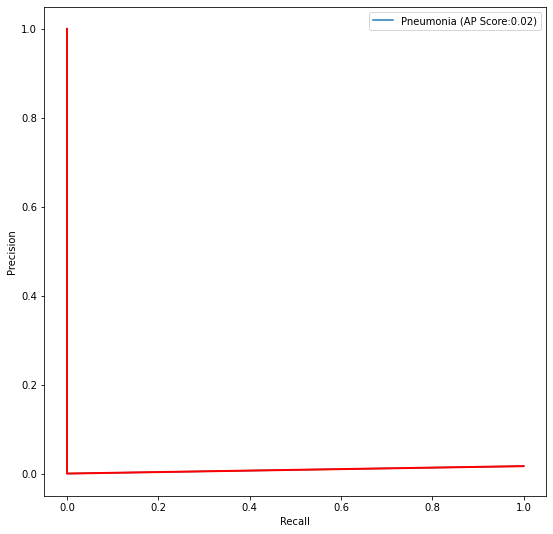

In [64]:
f1, prec, recall,threshold =plot_precision_recall_curve_helper(valY, pred_Y)


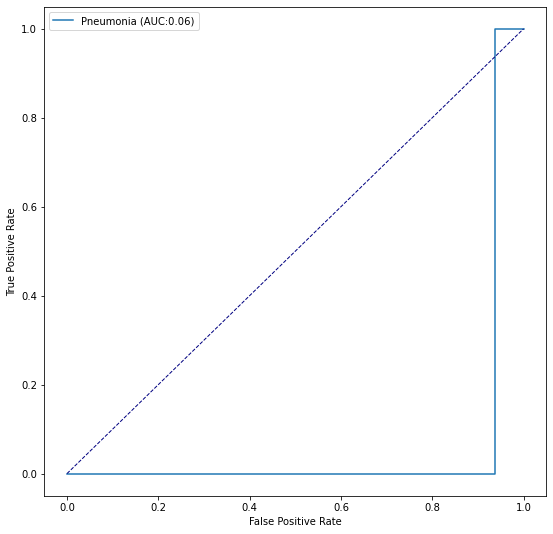

In [65]:
plot_auc(valY, pred_Y)

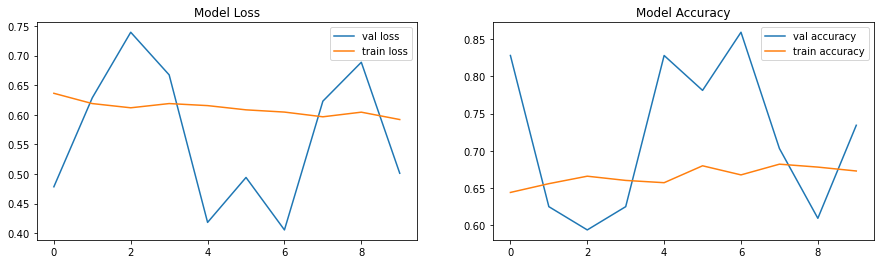

In [66]:
hist = plot_history(history)

In [68]:
# metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})
# metric_df

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [69]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score

# Assuming y_true are the true labels and y_scores are the predicted probabilities
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')
print(f'F1 Score at Optimal Threshold: {f1_scores[optimal_idx]}')


Optimal Threshold: 0.07210831344127655
F1 Score at Optimal Threshold: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [70]:
optimal_threshold = 0.038

# Calculate precision and recall at the optimal threshold
y_pred_optimal = (pred_Y >= optimal_threshold).astype(int)
precision_optimal = precision_score(valY, y_pred_optimal)
recall_optimal = recall_score(valY, y_pred_optimal)

print(f'Precision at Optimal Threshold: {precision_optimal}')
print(f'Recall at Optimal Threshold: {recall_optimal}')


Precision at Optimal Threshold: 0.015873015873015872
Recall at Optimal Threshold: 1.0


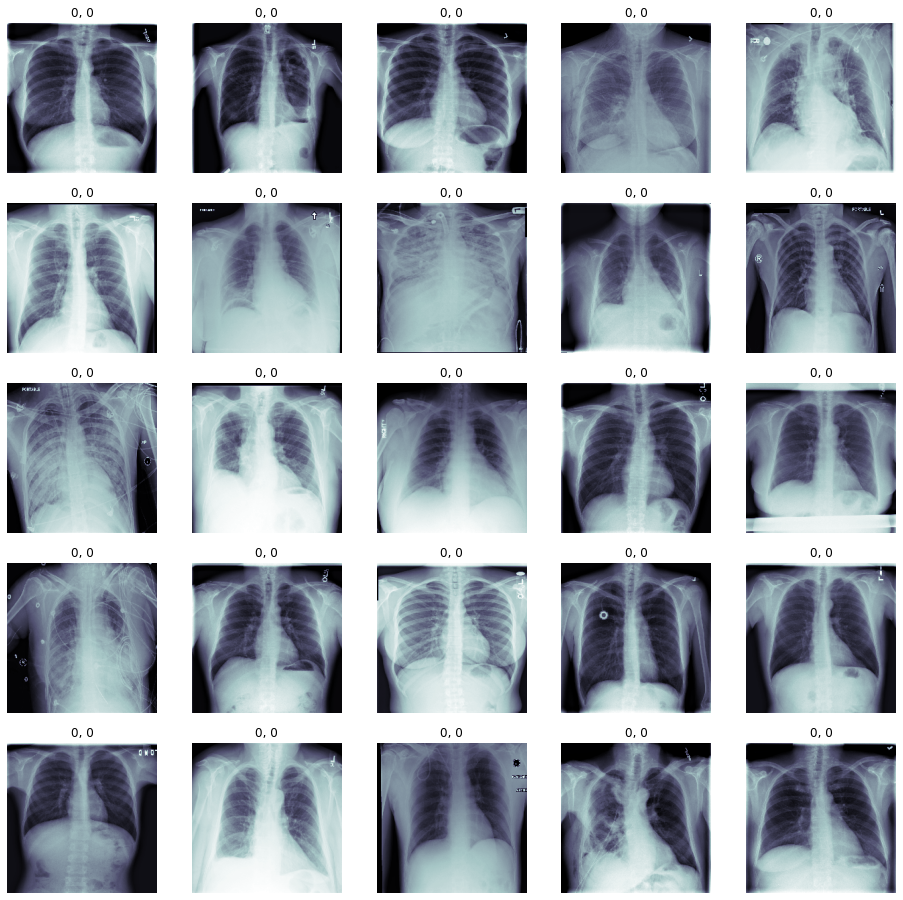

In [71]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
YOUR_THRESHOLD=0.67
fig, m_axs = plt.subplots(5,5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [72]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model2.json", "w") as json_file:
    json_file.write(model_json)